# Evaluate the question matcher using the existing harmonisation tool as a gold standard



In [2]:
import sys

sys.path.append("../front_end")


import bz2
import os
import pickle as pkl
import re
import sys
from nltk.corpus import stopwords
from langdetect import detect
import numpy as np

import pandas as pd

from utils.pt_en_dict import pt_en_map
from utils.spacy_wrapper import get_spacy_model


In [3]:
INPUT_FILE = "../data/Final harmonised item tool EM.xlsx"


In [4]:
initial_number_regex = re.compile(r'^\d+\.')

In [5]:
question_to_category_for_gold_standard = {}

# TODO: do Adulthood separately
question_dfs = []
for sheet_name in ("Childhood",):
    df = pd.read_excel(INPUT_FILE, sheet_name=sheet_name)

    if sheet_name == "Adulthood":
        labels_in_this_sheet = ["Adulthood"] * len(df)
        df = df[df.columns[4:]]
    else:
        labels_in_this_sheet = list(df["Developmental period"])
        df = df[df.columns[5:]]
        

    for idx in range(0, len(df)):
        if idx > 10:
            break
        questions = {}
        
        q_to_c = {}
        ctr = 0
        
        for j in range(len(df.columns)):
            col_name = df.columns[j]
            text = df[col_name].iloc[idx]
            if type(text) is str and len(text) > 1:
                for q in text.split("/"):
                    q = q.strip()
                    
                    m = initial_number_regex.match(q)
                    if m:
                        number = int(re.sub(r'\.', '', m.group()))
                        questions[number] = initial_number_regex.sub("", q).strip()
                        q_to_c[number] = col_name.strip()
                    elif len(q) > 1:
                        number = ctr
                        questions[number] = q
                        q_to_c[number] = col_name.strip()
                        ctr += 1
        
        if len(questions) > 0:
            question_df = pd.DataFrame({"number":sorted(questions)})
            for j in range(len(question_df)):
                q_no = question_df.number.iloc[j]
                question_to_category_for_gold_standard[(len(question_dfs), j)] = q_to_c[q_no]


            question_df.attrs["language"] = "en"
            question_df["question"] = question_df.number.apply(lambda n : questions[n])
        
        
        
        
            question_dfs.append(question_df)

In [6]:
category_to_question_groups_for_gold_standard = {}
for key, value in question_to_category_for_gold_standard.items():
    category_to_question_groups_for_gold_standard.setdefault(value, [])
    category_to_question_groups_for_gold_standard[value].append(key)

In [7]:
gold_standard = []
for key, groups in category_to_question_groups_for_gold_standard.items():
    if len(groups) > 1:
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                gold_standard.append((groups[i][0], groups[i][1], groups[j][0], groups[j][1]))

In [8]:
gold_standard_dict = {}
for i in range(len(question_dfs)):
    for idx in range(len(question_dfs[i])):
        for j in range(i + 1, len(question_dfs)):
            for jdx in range(len(question_dfs[j])):
                gold_standard_dict[(i, idx, j, jdx)] = 0
for g in gold_standard:
    gold_standard_dict[g] = 1

In [9]:
len(gold_standard_dict)

30007

In [10]:
len(question_dfs)

11

In [12]:
from utils.question_matcher_nonpretrained import QuestionMatcherNonpretrained

In [13]:
qm = QuestionMatcherNonpretrained(stops = [])

In [14]:
matches = qm.match_questions(question_dfs)

In [15]:
matches_pruned = [m for m in matches if matches[m] > 0.5]

print ("Number of matches found", len(set(matches_pruned)))
print ("Number of matches in gold standard", len(set(gold_standard)))
print ("Number of matches found which were in gold standard",len(set(matches_pruned).intersection(set(gold_standard))))
print ("Number of matches found which were not in standard",len(set(matches_pruned).difference(set(gold_standard))))

print ("Jaccard", len(set(matches_pruned).intersection(set(gold_standard))) / len(set(matches_pruned).union(set(gold_standard))))

Number of matches found 328
Number of matches in gold standard 2102
Number of matches found which were in gold standard 305
Number of matches found which were not in standard 23
Jaccard 0.14352941176470588


In [16]:
for m in matches_pruned:
    if m in gold_standard:
        print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]])

Cries Easily = She cries easily
Is Kind to Young Children = Is kind to younger children
Is Kind to Animals = Is kind to younger children
Appears Miserable or Tearful = Often appears miserable, unhappy, tearful or distressed
Is Disobedient = Is often disobedient
Destroys Own Others Belongings = Often destroys own or others’ belongings
Worries about Many Things = Often worried, worries about many things
Is Afraid of New Things = Tends to be fearful or afraid of new things or new situations.
Twitches or Has Tics = Has twitches, mannerisms or tics of the face or body
Is Squirmy and Fidgety = Is squirmy or fidgety
Is Fussy or Over Particular = Is over fussy or over particular
Appears Miserable or Tearful = Child appears miserable, unhappy, tearful or distressed
Fights With Other Children = Child fights with other children
Is Disobedient = Child is disobedient
Worries about Many Things = Child worries about many things
Is Afraid of New Things = Child is afraid of new things or new situations

In [17]:
for m in matches_pruned:
    if m not in gold_standard:
        print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]])

Gets on With Other Children = Gets on better with adults than with other children
Does things on Own = Tends to do things on his
Other Children Dislike Child = Child bullies other children
Gets on With Other Children = Gets on better with adults than with other children
Other Children Dislike Child = Child bullies other children
Does things on Own = Prefers to do things on his
Gets on With Other Children = Gets on better with adults than with other children
Is picked on or bullied by other children = Bullies other children
Is picked on or bullied by other children = Child bullies other children
Is picked on or bullied by other children = Child bullies other children
Cannot settle to anything for more than a few moments. = Child cannot settle to do anything for more than a few moments
Bullies other children = Is picked on or bullied by other children
Cannot settle to anything for more than a few moments. = Child cannot settle to do anything for more than a few moments
Bullies other chil

In [18]:
for m in gold_standard:
    if m not in matches:
        print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]])

Child appears miserable, unhappy, tearful or distressed = Child laughs a lot
Child appears miserable, unhappy, tearful or distressed = Child really enjoys life
Child laughs a lot = Child really enjoys life
Child appears miserable, unhappy, tearful or distressed = Child laughs a lot
Child appears miserable, unhappy, tearful or distressed = Child really enjoys life
Child laughs a lot = Child really enjoys life
Fights With Other Children = Bullies Other Children
Fights With Other Children = Bites or Kicks Other Children
Bullies Other Children = Bites or Kicks Other Children
Frequently fights other children = Bullies other children
Child fights with other children = Child bullies other children
Child fights with other children = Child bullies other children
Is Disobedient = Is Inconsiderate of Others
Is generally obedient, usually does what adults request = Often argumentative with adults
Tells Lies = Blames Other for Things
Tries to be Fair in Games = Is Affectionate to Family Members
Tri

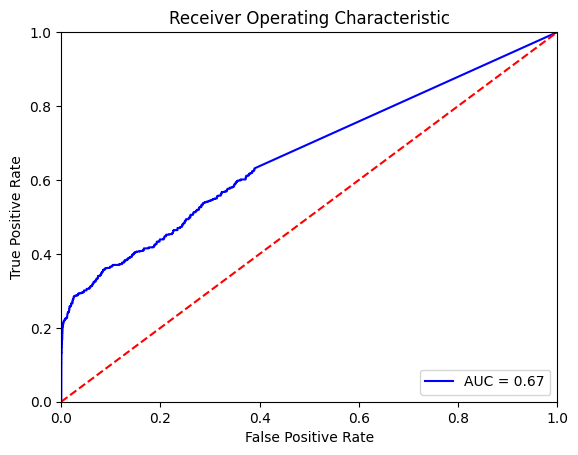

In [19]:
import sklearn.metrics as metrics

y_pred = []
y_test = []
for m, g in gold_standard_dict.items():
    y_pred.append(matches.get(m, 0))
    y_test.append(g)
    
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
print ("FALSE NEGATIVES")

import operator 
all_positives = [m for m in gold_standard_dict if gold_standard_dict[m] == 1 ]
estimated_values_for_gt_1 = dict([(m, matches.get(m, 0)) for m in all_positives])

for m, v in sorted(estimated_values_for_gt_1.items(), key=operator.itemgetter(1)):
    print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]], v)

FALSE NEGATIVES
Appears Miserable or Tearful = Child laughs a lot 0.0
Appears Miserable or Tearful = Child really enjoys life 0.0
Appears Miserable or Tearful = Child laughs a lot 0.0
Appears Miserable or Tearful = Child really enjoys life 0.0
Is Irritable = She reacts intensely when upset 0.0
Is Irritable = Often has temper tantrums or hot tempers 0.0
Is Irritable = She reacts intensely when upset 0.0
Is Irritable = Often has temper tantrums or hot tempers 0.0
Is Irritable = She reacts intensely when upset 0.0
Is Irritable = Often has temper tantrums or hot tempers 0.0
Is Disobedient = Often argumentative with adults 0.0
Is Inconsiderate of Others = Often argumentative with adults 0.0
Tells Lies = Often tells lies 0.0
Tells Lies = Child tells lies 0.0
Tells Lies = Often lies or cheats 0.0
Tells Lies = Child tells lies 0.0
Tells Lies = Often lies or cheats 0.0
Blames Other for Things = Often tells lies 0.0
Blames Other for Things = Child tells lies 0.0
Blames Other for Things = Often l

In [21]:
print ("FALSE POSITIVES")

import operator 
all_negatives = [m for m in gold_standard_dict if gold_standard_dict[m] == 0 ]
estimated_values_for_gt_0 = dict([(m, matches.get(m, 0)) for m in all_negatives])

for m, v in sorted(estimated_values_for_gt_0.items(), key=operator.itemgetter(1), reverse=True):
    print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]], v)

FALSE POSITIVES
Cannot settle to anything for more than a few moments. = Child cannot settle to do anything for more than a few moments 0.9447784999026987
Cannot settle to anything for more than a few moments. = Child cannot settle to do anything for more than a few moments 0.9447784999026987
Bullies other children = Is bullied by other children 0.7700131202269942
Child bullies other children = Is bullied by other children 0.7325428726414465
Child bullies other children = Is bullied by other children 0.7325428726414465
Child cannot settle to do anything for more than a few moments = Has difficulty in settling to anything for more than a few moments 0.7114478001736467
Child cannot settle to do anything for more than a few moments = Has difficulty in settling to anything for more than a few moments 0.7114478001736467
Gets on With Other Children = Gets on better with adults than with other children 0.6151250187157935
Gets on With Other Children = Gets on better with adults than with other

She is very energentic = She prefers playing with other rather than alone 0.07887165567267251
Has twitches, mannerisms or tics of the face or body = Is irritable, quick to fly off the handle 0.0788081167070668
She is very sociable = Is often disobedient 0.07879577999863822
She is very energentic = Is often disobedient 0.07879577999863822
Is often disobedient = She is very sociable 0.07879577999863822
Is often disobedient = She is very energentic 0.07879577999863822
Is often disobedient = She is very sociable 0.07879577999863822
Is often disobedient = She is very energentic 0.07879577999863822
Destroys Own Others Belongings = Not much liked by other children. 0.07870596856522596
Bites or Kicks Other Children = Tends to be fearful or afraid of new things or new situations. 0.07870450882577455
Often destroys own or others’ belongings = Child is squirmy or fidgety 0.07866420866391534
Often destroys own or others’ belongings = Child is squirmy or fidgety 0.07866420866391534
Is constantly fi

Is kind to younger children = Child bites their nails or fingers 0.06317875367376745
Is kind to younger children = Child bites their nails or fingers 0.06317875367376745
Child bites their nails or fingers = Is kind to younger children 0.06317875367376745
Child bites their nails or fingers = Is kind to younger children 0.06317875367376745
Is kind to younger children = Child bites their nails or fingers 0.06317875367376745
Child bites their nails or fingers = Is kind to younger children 0.06317875367376745
Has Stutter or Stammer = Often fights with other children or bullies them 0.06317738769491776
Has Stutter or Stammer = Often fights with other children or bullies them 0.06317738769491776
Has Stutter or Stammer = Often fights with other children or bullies them 0.06317738769491776
She tends to be shy = She finds people more stimulating than anything else 0.0631729823306101
She tends to be shy = She finds people more stimulating than anything else 0.0631729823306101
She finds people mor

Is restless, overactive, cannot stay still for long = She tends to be somewhat emotional 0.02816543352485246
She tends to be somewhat emotional = Is restless, overactive, cannot stay still for long 0.02816543352485246
Is Kind to Young Children = Is nervous or clingy in new situations, easily loses confidence 0.028133368090296266
Is Kind to Young Children = Is nervous or clingy in new situations, easily loses confidence 0.028133368090296266
Is Kind to Young Children = Is nervous or clingy in new situations, easily loses confidence 0.028133368090296266
She is always on the go = Child is afraid of new things or new situations 0.02806536428849499
She is always on the go = Child is afraid of new things or new situations 0.02806536428849499
Child is afraid of new things or new situations = She is always on the go 0.02806536428849499
Child is afraid of new things or new situations = She is always on the go 0.02806536428849499
She is always on the go = Child is afraid of new things or new situ

Destroys Own Others Belongings = She is very friendly with strangers 0.0
Destroys Own Others Belongings = Is restless, overactive, cannot stay still for long 0.0
Destroys Own Others Belongings = Often complains of headaches, stomach-aches or sickness 0.0
Destroys Own Others Belongings = Often has temper tantrums or hot tempers 0.0
Destroys Own Others Belongings = Is rather solitary, tends to play alone 0.0
Destroys Own Others Belongings = Is generally obedient, usually does what adults request 0.0
Destroys Own Others Belongings = Has many worries, often seems worried 0.0
Destroys Own Others Belongings = Is helpful if someone is hurt, upset or feeling ill 0.0
Destroys Own Others Belongings = Is constantly fidgeting or squirming 0.0
Destroys Own Others Belongings = Has at least one good friends 0.0
Destroys Own Others Belongings = Is often unhappy, down hearted or tearful 0.0
Destroys Own Others Belongings = Is easily distracted, concentration wanders 0.0
Destroys Own Others Belongings =

Has Stutter or Stammer = Often volunteers to help others (parents, teachers, other children) 0.0
Has Stutter or Stammer = Thinks things out before acting 0.0
Has Stutter or Stammer = Gets on better with adults than with other children 0.0
Has Stutter or Stammer = Child laughs a lot 0.0
Has Stutter or Stammer = Child really enjoys life 0.0
Has Stutter or Stammer = Child fights with other children 0.0
Has Stutter or Stammer = Child bullies other children 0.0
Has Stutter or Stammer = Child is irritable. Is quick to fly off the handle 0.0
Has Stutter or Stammer = Child is disobedient 0.0
Has Stutter or Stammer = Child worries about many things 0.0
Has Stutter or Stammer = Child tells lies 0.0
Has Stutter or Stammer = Child takes things belonging to others 0.0
Has Stutter or Stammer = Child likes a cuddle 0.0
Has Stutter or Stammer = Child smiles when child sees their parent(s) 0.0
Has Stutter or Stammer = Child cannot settle to do anything for more than a few moments 0.0
Has Stutter or Sta

She finds people more stimulating than anything else = Sometimes takes things belonging to others 0.0
She finds people more stimulating than anything else = Has twitches, mannerisms or tics of the face or body 0.0
She finds people more stimulating than anything else = Frequently sucks thumb or finger 0.0
She finds people more stimulating than anything else = Frequently bites nails or fingers 0.0
She finds people more stimulating than anything else = Is often disobedient 0.0
She finds people more stimulating than anything else = Tends to be fearful or afraid of new things or new situations. 0.0
She finds people more stimulating than anything else = Is over fussy or over particular 0.0
She finds people more stimulating than anything else = Often tells lies 0.0
She finds people more stimulating than anything else = Bullies other children 0.0
She finds people more stimulating than anything else = Child appears miserable, unhappy, tearful or distressed 0.0
She finds people more stimulating 

Child laughs a lot = Thinks things out before acting 0.0
Child laughs a lot = Steals from home, school or elsewhere 0.0
Child laughs a lot = Has many fears, is easily scared 0.0
Child laughs a lot = Sees tasks through to the end, has good attention span 0.0
Child laughs a lot = She tends to be shy 0.0
Child laughs a lot = She cries easily 0.0
Child laughs a lot = She likes to be with people 0.0
Child laughs a lot = She is always on the go 0.0
Child laughs a lot = She prefers playing with other rather than alone 0.0
Child laughs a lot = She tends to be somewhat emotional 0.0
Child laughs a lot = When she moves about she tends to move slowly 0.0
Child laughs a lot = She makes friends easily 0.0
Child laughs a lot = She is off and running as soon as she wakes up in the morning 0.0
Child laughs a lot = She finds people more stimulating than anything else 0.0
Child laughs a lot = She often fusses and cries 0.0
Child laughs a lot = She is very sociable 0.0
Child laughs a lot = She is very en

She is very energentic = Shares readily with other children (treats, toys, pencils etc) 0.0
She is very energentic = Often has temper tantrums or hot tempers 0.0
She is very energentic = Has many worries, often seems worried 0.0
She is very energentic = Has at least one good friends 0.0
She is very energentic = Often fights with other children or bullies them 0.0
She is very energentic = Often lies or cheats 0.0
She is very energentic = Often volunteers to help others (parents, teachers, other children) 0.0
She is very energentic = Thinks things out before acting 0.0
She is very energentic = Steals from home, school or elsewhere 0.0
She is very energentic = Gets on better with adults than with other children 0.0
She is very energentic = Sees tasks through to the end, has good attention span 0.0
She is very energentic = Child appears miserable, unhappy, tearful or distressed 0.0
She is very energentic = Child laughs a lot 0.0
She is very energentic = Child really enjoys life 0.0
She is 